In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from matplotlib.ticker import ScalarFormatter

# Public economics seminar II - country-by-country reporting
Daniel Kolář

## How to identify the main tax havens?

**Effective tax rate**


Income tax accrued/Pre-tax profit

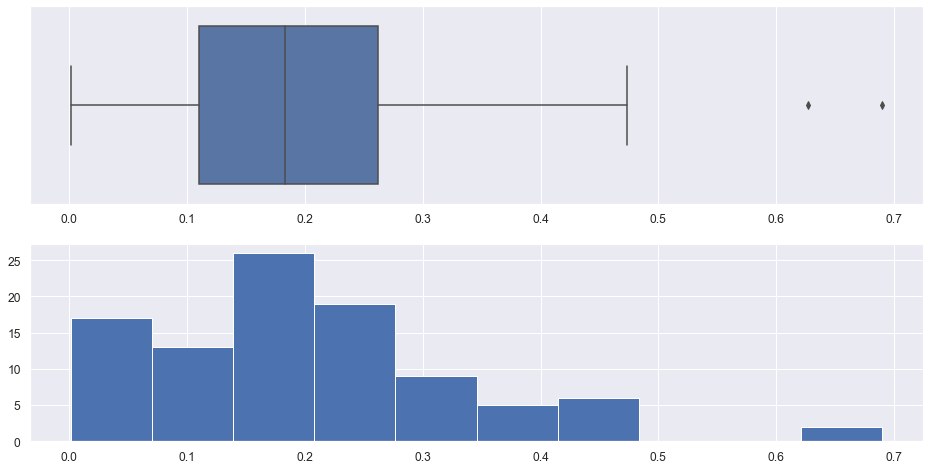

In [2]:
sns.set(font_scale=1.1)
#load data
data=pd.read_csv("irs_cbcr.csv",index_col="Country")
#rename some columns
data=data.rename(columns={"Profit (loss) before income tax": "Profit", "Income tax accrued": "Tax", "No of MNCs":"No",\
                         "Tangible assets other than cash":"Total assets"})

#drop stateless entities:
data=data[data.index!="Stateless entities and other country"]
# di=["other countries" in i for i in data.index]
# di=[not elem for elem in di]
# data=data[di]
# data=data[data.index!="United States"]

#effective tax rate
etr=data.Tax/data.Profit
data["Etr"]=data.Tax/data.Profit

fig,ax=plt.subplots(2,1,figsize=(16,8))
sns.boxplot(ax=ax[0],x=etr)
ax[1].hist(etr)
plt.show()

In [3]:
#lowest ETR
etr.sort_values(ascending=True).head(10)

Country
Jersey                       0.001322
Cayman Islands               0.005035
Europe, other countries      0.007362
Luxembourg                   0.009108
Puerto Rico                  0.014345
Bermuda                      0.014889
Americas, other countries    0.022944
Bahrain                      0.023300
Hungary                      0.025205
Mauritius                    0.027278
dtype: float64

In [4]:
#highest ETR
etr.sort_values(ascending=False).head(10)

Country
Nigeria                 0.690179
Burma                   0.627341
Italy                   0.473413
Norway                  0.463917
Tanzania                0.443397
United Arab Emirates    0.431882
Kenya                   0.428197
Colombia                0.418361
Bangladesh              0.400278
Angola                  0.396922
dtype: float64

**Effective vs statutory tax rate**

Source for corporate income tax (CIT) for year 2017: [OECD](https://stats.oecd.org/Index.aspx?DataSetCode=CTS_CIT)

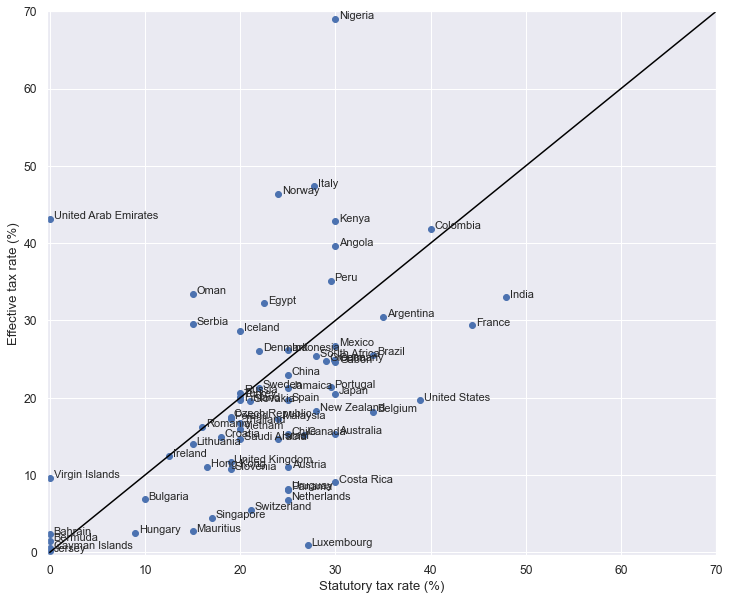

In [5]:
cit_df=pd.read_csv("cit_oecd.csv",index_col="Country")
cit_df.index=cit_df.index.str.strip()
data2=data.merge(cit_df,how="inner",left_index=True,right_index=True)
data2.rename(index={'United Kingdom (England, Northern Ireland, Scotland, and Wales)':'United Kingdom'},inplace=True)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

ax.plot(data2.cit,data2.Etr*100,marker="o",linestyle="")
ax.plot(np.arange(71),np.arange(71),marker="",linestyle=None,color="black")
for i in data2.index:
    plt.text(data2.loc[i,].cit+0.4,data2.loc[i,].Etr*100, i,fontsize=11)

ax.set_xlabel("Statutory tax rate (%)")
ax.set_ylabel("Effective tax rate (%)")

ax.set_xlim(left=-0.33,right=70)
ax.set_ylim(top=70,bottom=-0.33)

plt.show()

**Why does effective tax rate and statutory tax rate differ?** \
*ETRs reveal the effect of tax deductions (including tax holidays and other ad hoc arrangements) and other tax provisions that co-determine tax paid by MNCs and how they differ across countries. For example, if an MNC affiliate makes use of tax incentives or is granted an advantageous tax ruling, then its ETR is bound to be lower than the CIT.* (Garcia‑Bernando, Janský, Tørsløv 2021)


**Outlier - United Emirates** \
[Tax Justice Network country profile](https://cthi.taxjustice.net/en/cthi/profiles?country=AE):
According to KPMG: "The corporate tax rate applicable in the UAE ranges from 0-55%. (...) **In practice tax is currently only enforced on foreign oil companies engaged in the exploration and production of oil and branches of foreign banks.** The tax rate applicable to oil companies is generally 55% of operating profits. Branches of foreign banks are subject to tax at 20% of their profits under the banking tax decrees" (KPMG 2020).

Note: This highlights the need for un-aggregated data

**Technical note: We are dropping stateless entities** \
*These stateless entities include US-organized constituent entities that are fiscally transparent US business entities (perhaps including partnerships) as well as any other constituent entities of a US MNC group that do not have a tax jurisdiction of residence.(..) double counting of revenue and profits may occur.* (Garcia‑Bernando, Janský, Tørsløv 2021)

**Tax Justice Network: Corporate Tax Haven Index**

https://cthi.taxjustice.net/en/

## How to estimate the scope of profit shifting?

**Average profits**

Insufficient - doesn't control for real activity

African countries?

In [6]:
data.rename(index={'United Kingdom (England, Northern Ireland, Scotland, and Wales)':'United Kingdom'},inplace=True)
data["Avgprofit"]=data.Profit/data.No
data.loc[:,["Avgprofit","Etr"]].sort_values("Avgprofit",ascending=False).head(15)

,Avgprofit,Etr
Country,,
United States,1.197877e+09,0.196763
Jersey,3.029412e+08,0.001322
Cayman Islands,2.998520e+08,0.005035
Bermuda,2.286049e+08,0.014889
Luxembourg,2.069784e+08,0.009108
Puerto Rico,1.594430e+08,0.014345
Switzerland,1.306943e+08,0.054846
Netherlands,1.158342e+08,0.067947
United Kingdom,1.009514e+08,0.116360


**Relative party revenues/Total revenues**

In [7]:
aux=(data["Related party"]/data["Total"])
data["Rel/Tot"]=data["Related party"]/data["Total"]
data.loc[:,["Rel/Tot","Etr"]].sort_values("Rel/Tot",ascending=False).head(15)

,Rel/Tot,Etr
Country,,
Puerto Rico,0.904343,0.014345
Angola,0.864452,0.396922
Bermuda,0.850923,0.014889
"Americas, other countries",0.827902,0.022944
Cayman Islands,0.822302,0.005035
Nigeria,0.780138,0.690179
Luxembourg,0.728429,0.009108
"Europe, other countries",0.716429,0.007362
Netherlands,0.669434,0.067947


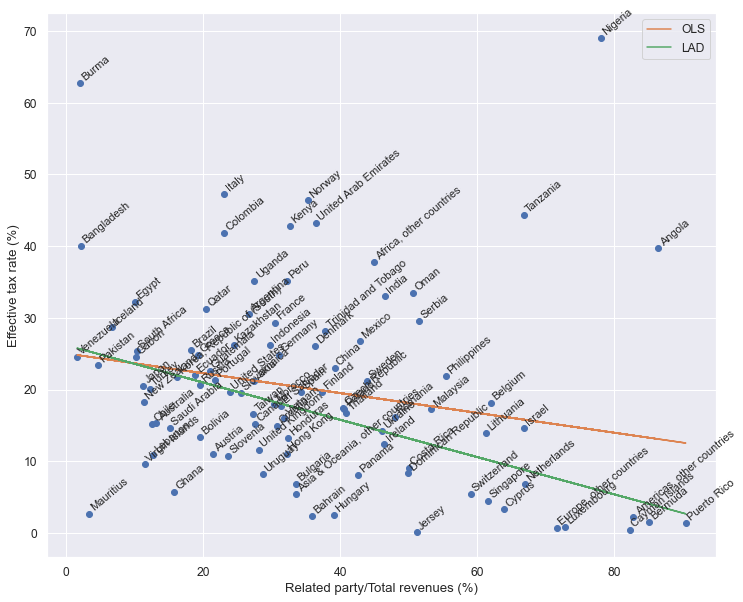

In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

x=data.Etr*100
y=np.array(data.Etr*100).reshape(-1,1)
X=np.array(data["Rel/Tot"]*100).reshape(-1,1)
x=data["Rel/Tot"]*100
ax.plot(X,y,marker="o",linestyle="")
#ax.plot(np.arange(71),np.arange(71),marker="",linestyle=None,color="black")
for i in data.index:
    j=list(data.index).index(i)
    plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=40)

ax.set_xlabel("Related party/Total revenues (%)")
ax.set_ylabel("Effective tax rate (%)")

#OLS
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b,label="OLS")

#LAD
def cost_function(aa):
    a=aa[0]
    b=aa[1]
    return np.sum(np.abs(y - a - b*X))
output = minimize(cost_function, [36,-0.2])
y_hat = output.x[0]+output.x[1]*X
plt.plot(X,y_hat,label="LAD")

#ax.set_xlim(left=-0.33,right=100)
#ax.set_ylim(top=70,bottom=-0.33)

plt.legend()
plt.show()

Ireland?

**Profit/Assets**

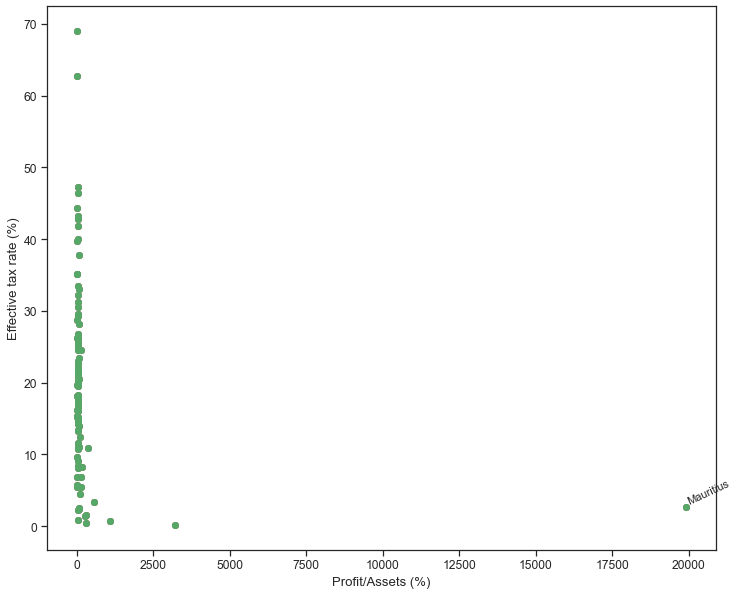

In [9]:
sns.set(font_scale=1.1,style='ticks')
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

x=data["Profit"]/data["Total assets"]*100
y=np.array(data.Etr*100).reshape(-1,1)
X=np.array(x).reshape(-1,1)
ax.plot(x,y,marker="o",linestyle="")
ax.plot(X,y,marker="o",linestyle="")
ax.plot(X,y,marker="o",linestyle="")
for i in data.index:
    j=list(data.index).index(i)
    if X[j]>4000:
        plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=25)

ax.set_xlabel("Profit/Assets (%)")
ax.set_ylabel("Effective tax rate (%)")
plt.show()

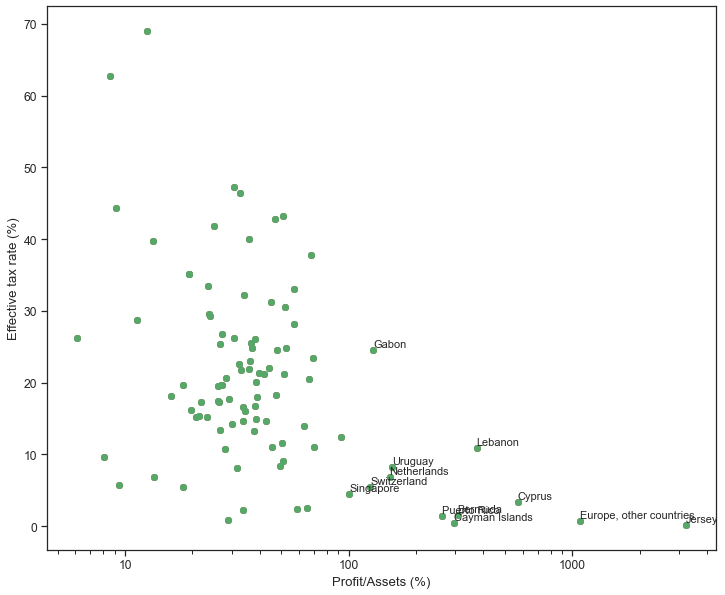

In [10]:
#remove outlier, try a log scale
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

cond=data.index!="Mauritius"
data3=data[cond]
x=data3["Profit"]/data3["Total assets"]*100
y=np.array(data3.Etr*100).reshape(-1,1)
X=np.array(x).reshape(-1,1)
ax.plot(x,y,marker="o",linestyle="")
ax.plot(X,y,marker="o",linestyle="")
ax.plot(X,y,marker="o",linestyle="")

for i in data3.index:
    j=list(data3.index).index(i)
    if X[j]>100:
        plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=0)
ax.set_xscale('log')

for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_xlabel("Profit/Assets (%)")
ax.set_ylabel("Effective tax rate (%)")
plt.show()

**Profit per employee**

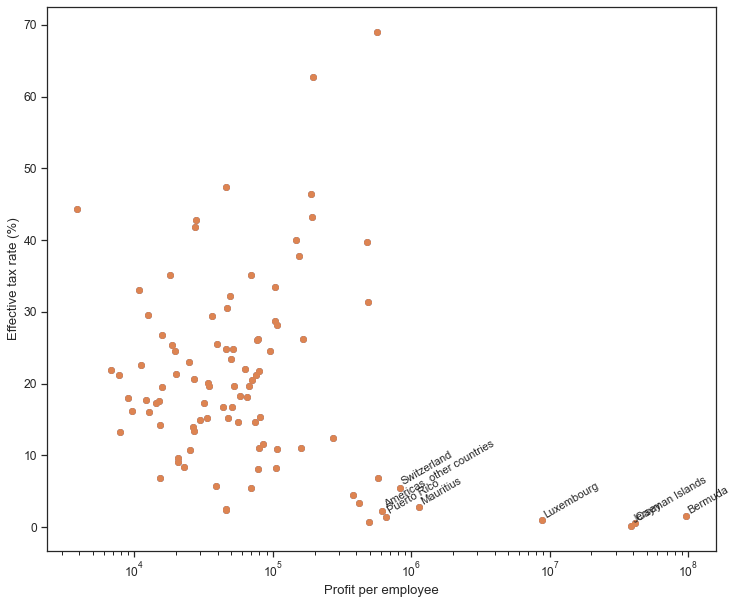

In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

x=data["Profit"]/data["Number of employees"]
y=np.array(data.Etr*100).reshape(-1,1)
X=np.array(x).reshape(-1,1)
ax.plot(x,y,marker="o",linestyle="")
ax.plot(X,y,marker="o",linestyle="")

for i in data.index:
    j=list(data.index).index(i)
    if X[j]>600000:
        plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=30)
ax.set_xscale('log')
ax.set_xlabel("Profit per employee")
ax.set_ylabel("Effective tax rate (%)")
plt.show()

In [12]:
#look at profit per employee at countries with the lowest ETR
data["PPE"]=data["Profit"]/data["Number of employees"]
data.loc[:,["PPE","Etr"]].sort_values("Etr",ascending=True).head(15)

,PPE,Etr
Country,,
Jersey,3.858601e+07,0.001322
Cayman Islands,4.130411e+07,0.005035
"Europe, other countries",4.935981e+05,0.007362
Luxembourg,8.832045e+06,0.009108
Puerto Rico,6.573925e+05,0.014345
Bermuda,9.602646e+07,0.014889
"Americas, other countries",6.164310e+05,0.022944
Bahrain,4.550860e+04,0.023300
Hungary,4.614067e+04,0.025205


What do you think about this approach? Could we improve it?

## Profit misalignment statistics

Used in economic papers, many of which are (co-)authored by Petr Janský

**Share of profits/Share of employees**

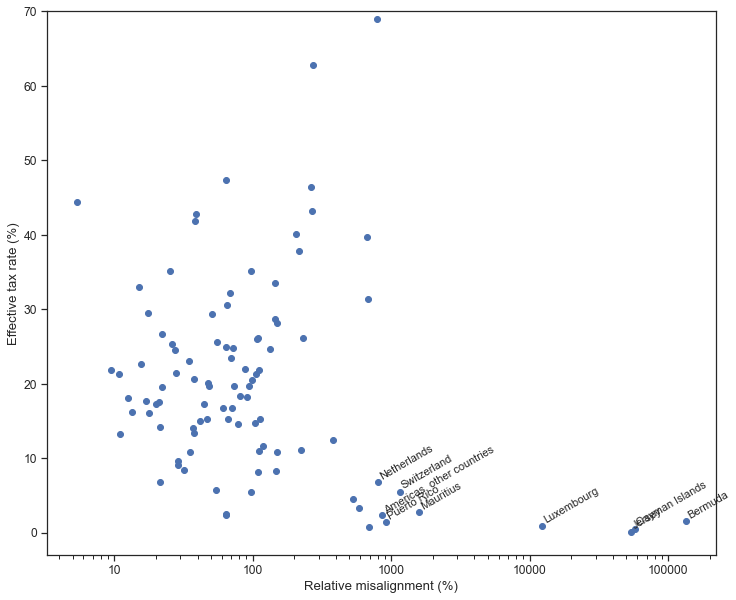

In [13]:
data["ProfitShare"]=data["Profit"]/data["Profit"].sum()
data["EmplShare"]=data["Number of employees"]/data["Number of employees"].sum()
data["PM1"]=data["ProfitShare"]/data["EmplShare"]

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

x=data["PM1"]*100
y=np.array(data.Etr*100).reshape(-1,1)
X=np.array(x).reshape(-1,1)
ax.plot(X,y,marker="o",linestyle="")
#ax.plot(np.repeat(100, 74),np.arange(-3,71),color="black")
ax.set_ylim(top=70,bottom=-3)
for i in data.index:
    j=list(data.index).index(i)
    if X[j]>800:
        plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=30)
ax.set_xlabel("Relative misalignment (%)")
ax.set_ylabel("Effective tax rate (%)")
ax.set_xscale('log')
for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.show()
#What would be the value of this statistics if all profits were perfectly aligned?

**Excess or missing profit (% of expected profits) - third party revenue**

*Expected profits = share of economic activity * total profits*

*Misaligned (Excess/missing) profit = observed profit - expected profit*


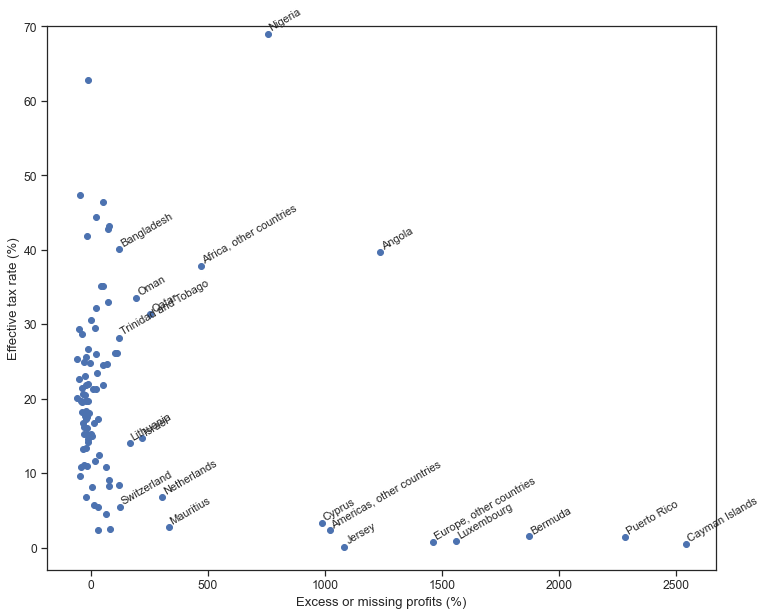

In [30]:
data["Share"]=data["Unrelated party"]/(data["Unrelated party"].sum())
data["ExpectedProfit"]=data["Share"]*(data["Profit"].sum())
data["MisalignedProfit"]=data["Profit"]-data["ExpectedProfit"]
data["PM2"]=data["MisalignedProfit"]/data.ExpectedProfit

x=data["PM2"]*100
y=np.array(data.Etr*100).reshape(-1,1)
X=np.array(x).reshape(-1,1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

ax.plot(X,y,marker="o",linestyle="")
#ax.plot(np.repeat(0, 74),np.arange(-3,71),color="black")
ax.set_ylim(top=70,bottom=-3)
for i in data.index:
    j=list(data.index).index(i)
    if X[j]>120:
        plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=30)
ax.set_xlabel("Excess or missing profits (%)")
ax.set_ylabel("Effective tax rate (%)")

plt.show()
#What is the value you would expect if all profits were perfectly aligned?

**Excess or missing profit (% of expected profits) - composite indicator**

1/3 weight of no. of employees, 1/3 of unrelated party revenue, 1/3 of assets

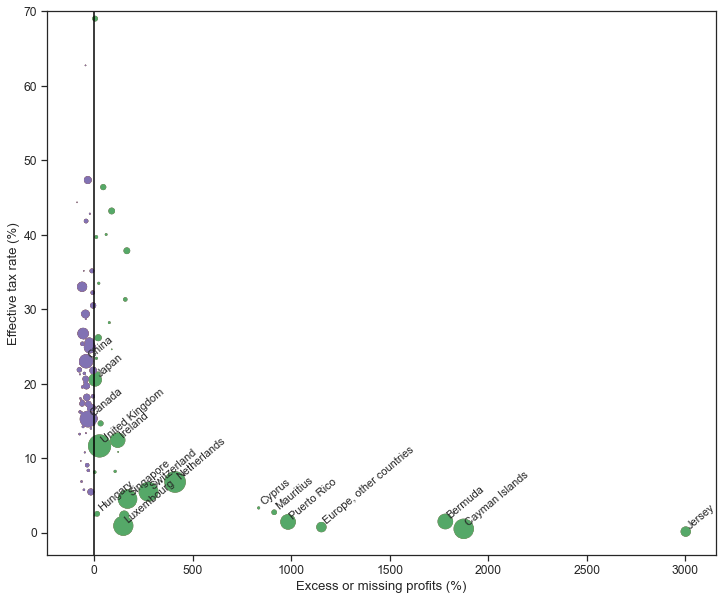

In [34]:
data["Share1"]=data["Number of employees"]/(data["Number of employees"].sum())
data["Share2"]=data["Unrelated party"]/(data["Unrelated party"].sum())
data["Share3"]=data["Total assets"]/(data["Total assets"].sum())
data["Share"]=(data["Share1"]+data["Share2"]+data["Share3"])/3
data["ExpectedProfit"]=data["Share"]*(data["Profit"].sum())
data["MisalignedProfit"]=data["Profit"]-data["ExpectedProfit"]
data["PM2"]=(data["MisalignedProfit"])/data.ExpectedProfit

data2=data.copy()
data2=data2[data2.index!="United States"]
x=data2["PM2"]*100
y=np.array(data2.Etr*100).reshape(-1,1)
X=np.array(x).reshape(-1,1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(X,y,marker="o",s=(data2["Profit"]/data2["Profit"].std()*100)  )
ax.scatter(X,y,marker="o",s=(data2["Profit"]/data2["Profit"].std()*100)  )
ax.scatter(X,y,marker="o",s=(data2["Profit"]/data2["Profit"].std()*100)  )
ax.scatter(X[data2["PM2"]<0],y[data2["PM2"]<0],marker="o",s=(data2[data2["PM2"]<0]["Profit"]/data2["Profit"].std()*100)  )
ax.scatter(X[data2["PM2"]<0],y[data2["PM2"]<0],marker="o",s=(data2[data2["PM2"]<0]["Profit"]/data2["Profit"].std()*100)  )

ax.plot(np.repeat(0, 74),np.arange(-3,71),color="black")
ax.set_ylim(top=70,bottom=-3)

for i in data2.index:
    j=list(data2.index).index(i)
    if X[j]>200 or (data2["Profit"][j]/data2["Profit"].std())>1.3 or y[j]<5 \
    and i!="Americas, other countries" and i!="Bahrain":
        plt.text(X[j],y[j]+0.4, i,fontsize=11,rotation=40)
ax.set_xlabel("Excess or missing profits (%)")
ax.set_ylabel("Effective tax rate (%)")

plt.show()